In [1]:
import numpy as np
import matplotlib.pyplot as plt
from corner import corner

import jax
import jax.numpy as jnp
import numpyro

In [2]:
scale = 10
alpha = 2
truth = numpyro.distributions.Pareto(scale, alpha)

In [3]:
nobs = 100
key = jax.random.PRNGKey(0)
obs = truth.sample(key, (nobs,))

In [4]:
def log_pop(x, alpha):
    shape = -(alpha+1) * jnp.log(x) - 30 / x
    norm = -alpha * jnp.log(30) + jnp.log(jax.scipy.special.gamma(alpha))
    return jnp.where(x > 0, shape - norm, -jnp.inf)

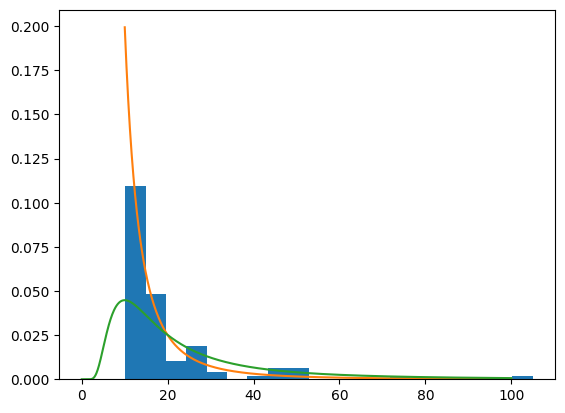

In [9]:
plt.hist(obs, bins=20, density=True)
x = jnp.linspace(0, 100, 1_000)
plt.plot(x[x>scale], jnp.exp(truth.log_prob(x[x>scale])))
plt.plot(x, jnp.exp(log_pop(x, alpha)));

## no uncertainty

In [53]:
def model(obs, truth):
    alpha = numpyro.sample('alpha', numpyro.distributions.Uniform(0, 10))
    if truth:
        lls = numpyro.distributions.Pareto(scale, alpha).log_prob(obs)
    else:
        lls = log_pop(obs, alpha)
    ll = jnp.sum(lls)
    numpyro.factor('ll', ll)

In [16]:
mcmc = {}
for truth in True, False:
    nuts = numpyro.infer.NUTS(model)
    mcmc[truth] = numpyro.infer.MCMC(sampler=nuts, num_warmup=1_000, num_samples=10_000)
    mcmc[truth].run(key, obs, truth)
    mcmc[truth].print_summary()

sample: 100%|█████| 11000/11000 [00:05<00:00, 1915.10it/s, 3 steps of size 8.48e-01. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      1.94      0.19      1.94      1.62      2.24   3644.13      1.00

Number of divergences: 0


sample: 100%|█████| 11000/11000 [00:05<00:00, 2143.49it/s, 3 steps of size 8.59e-01. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      2.27      0.14      2.26      2.04      2.49   3655.33      1.00

Number of divergences: 0


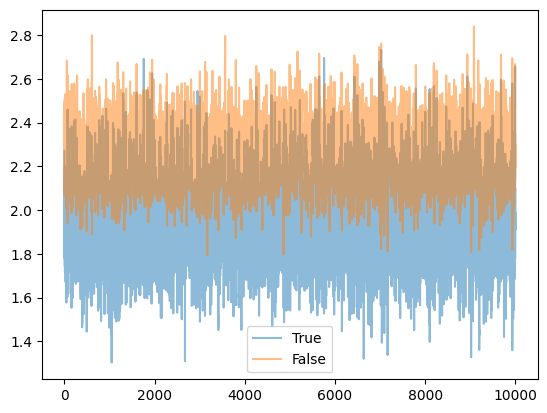

In [23]:
for truth in mcmc:
    plt.plot(mcmc[truth].get_samples()['alpha'], alpha=0.5, label=truth)
plt.legend();

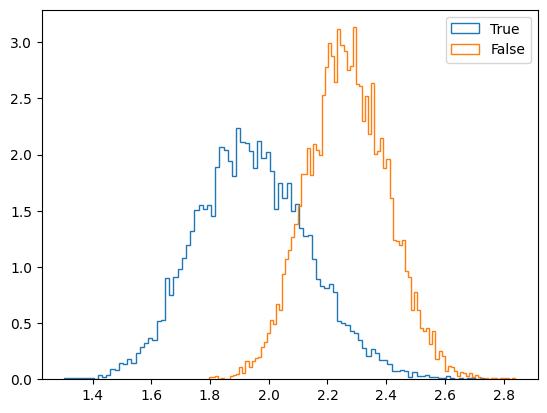

In [27]:
for truth in mcmc:
    plt.hist(mcmc[truth].get_samples()['alpha'], bins=100, density=True, histtype='step', label=truth)
plt.legend();

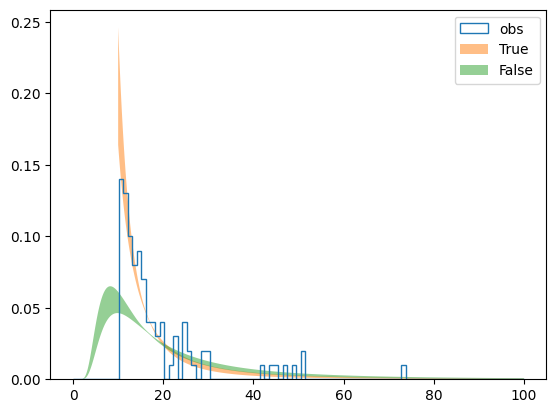

In [51]:
plt.hist(obs, bins=np.linspace(0, 100, 100), density=True, label='obs', histtype='step')
for truth in mcmc:
    x = jnp.linspace(0, 100, 1_000)
    if truth:
        ly = jax.vmap(lambda a: numpyro.distributions.Pareto(scale, a).log_prob(x))(mcmc[truth].get_samples()['alpha'])
        ly = ly[:, x>scale]
        x = x[x>scale]
    else:
        ly = jax.vmap(lambda a: log_pop(x, a))(mcmc[truth].get_samples()['alpha'])
    y = jnp.exp(ly)
    qs = np.quantile(y, [0.05, 0.995], axis=0)
    plt.fill_between(x, *qs, alpha=0.5, label=truth)
plt.legend();

## Gaussian likelihoods

In [52]:
nsamples = 1_000
posteriors = numpyro.distributions.Normal(
    loc=obs, scale=1,
    ).sample(key, (nsamples,)).T

posteriors.shape

(100, 1000)

In [54]:
def model(posteriors, truth):
    alpha = numpyro.sample('alpha', numpyro.distributions.Uniform(0, 10))
    if truth:
        lps = numpyro.distributions.Pareto(scale, alpha).log_prob(posteriors)
    else:
        lps = log_pop(posteriors, alpha)
    lls = jax.nn.logsumexp(lps, axis=1) - jnp.log(lps.shape[1])
    ll = jnp.sum(lls)
    numpyro.factor('ll', ll)

In [56]:
mcmc = {}
for truth in True, False:
    nuts = numpyro.infer.NUTS(model)
    mcmc[truth] = numpyro.infer.MCMC(sampler=nuts, num_warmup=1_000, num_samples=10_000)
    mcmc[truth].run(key, posteriors, truth)
    mcmc[truth].print_summary()

sample: 100%|██████| 11000/11000 [00:22<00:00, 493.51it/s, 3 steps of size 1.02e+00. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      2.01      0.20      2.01      1.69      2.35   3724.11      1.00

Number of divergences: 0


sample: 100%|██████| 11000/11000 [00:38<00:00, 284.32it/s, 7 steps of size 8.58e-01. acc. prob=0.95]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      2.28      0.14      2.28      2.06      2.50   3609.28      1.00

Number of divergences: 0


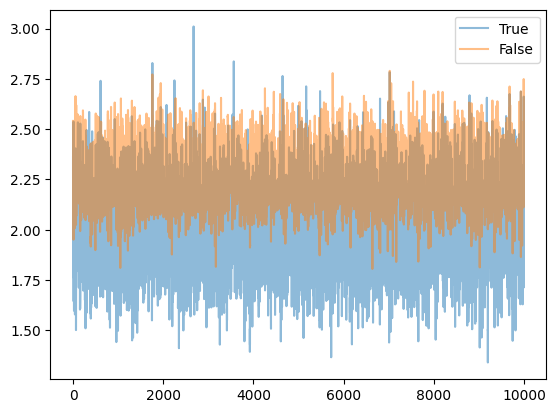

In [57]:
for truth in mcmc:
    plt.plot(mcmc[truth].get_samples()['alpha'], alpha=0.5, label=truth)
plt.legend();

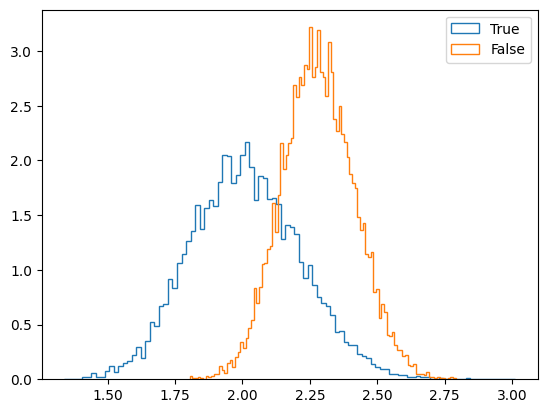

In [58]:
for truth in mcmc:
    plt.hist(mcmc[truth].get_samples()['alpha'], bins=100, density=True, histtype='step', label=truth)
plt.legend();

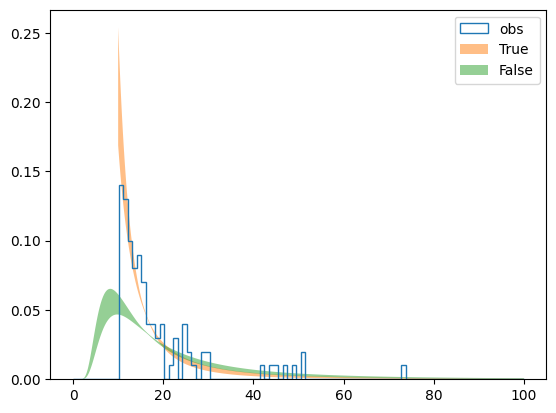

In [59]:
plt.hist(obs, bins=np.linspace(0, 100, 100), density=True, label='obs', histtype='step')
for truth in mcmc:
    x = jnp.linspace(0, 100, 1_000)
    if truth:
        ly = jax.vmap(lambda a: numpyro.distributions.Pareto(scale, a).log_prob(x))(mcmc[truth].get_samples()['alpha'])
        ly = ly[:, x>scale]
        x = x[x>scale]
    else:
        ly = jax.vmap(lambda a: log_pop(x, a))(mcmc[truth].get_samples()['alpha'])
    y = jnp.exp(ly)
    qs = np.quantile(y, [0.05, 0.995], axis=0)
    plt.fill_between(x, *qs, alpha=0.5, label=truth)
plt.legend();